<a href="https://colab.research.google.com/github/annguyenhuynh/PySpark/blob/main/Spark_Chap24_AdvancedAnalytics%26ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 540.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58749 sha256=9101299517b6ced6eaff4cb36d5f5d60f02f42a8fa5dcdd8a021eee5d5c5e9cf
  Stored in directory: /root/.cache/pip/wheels/63/88/77/b4131110ea4094540f7b47c6d62a649807d7e94800da5eab0b
Successfully built spark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=3bd2dd871e3eb0804a44faf0a1484598846ac57e1c3b476b619fdbcf25201395
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("machineLearning").getOrCreate()

# **MLlib in Action**

In [4]:
# Read in data
df = spark.read.json("/content/drive/MyDrive/databricks Spark-The-Definitive-Guide master data-simple-ml")

In [5]:
df.orderBy("value2").show()

+-----+----+------+------------------+
|color| lab|value1|            value2|
+-----+----+------+------------------+
|green|good|     1|14.386294994851129|
|green| bad|    16|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|    12|14.386294994851129|
|green| bad|    16|14.386294994851129|
|green|good|    12|14.386294994851129|
|  red|good|    35|14.386294994851129|
|  red|good|    35|14.386294994851129|
|  red| bad|     2|14.386294994851129|
|  red| bad|    16|14.386294994851129|
|  red| bad|    16|14.386294994851129|
| blue| bad|     8|14.386294994851129|
|green|good|     1|14.386294994851129|
|green|good|    12|14.386294994851129|
| blue| bad|     8|14.386294994851129|
|  red|good|    35|14.386294994851129|
| blue| bad|    12|14.386294994851129|
|  red| bad|    16|14.386294994851129|
|green|good|    12|14.386294994851129|
+-----+----+------+------------------+
only showing top 20 rows



**Feature Engineering with Transformers**

* Transformers help manipulate current columnd with the purpose of building features for our model.
* Transformers exists to either cut down the number of features, add more features, manipulate current ones, or simply help us format data correctly.
* Transformers add new columns to DF.
* When we use MLlib, most of the time, all the inputs in ML algorithm in Spark must consist of type **Double(for labels)** and **Vector[Double](for features)**
* We can transform data using **RFormula**. This is a DECLARATIVE language for specifying machine learning transformations

In [6]:
from pyspark.ml.feature import RFormula

In [7]:
supervised = RFormula(formula="lab ~ . + color:value1 + color:value2")

Breaking of the code:
  * The code above specify the formula for transformation using RFormlula
  * The `lab` is the target column we want to predict
  * `.` represents all the columns except the dependent variable. In this case, all other columns are used as features
  * `color:value1` + `color:value2` are interaction terms. This indicates that the product of color column with value 1 and value 2 should be added into the model as additional feautres

❓Why do we do RFormula?
* RFormula will automatically handles categorical varialbes. For it to do so,we need to call the **fit** method so that RFormula can determine which columns are categorical and the distinct values of the categorical columns


In [8]:
fittedR = supervised.fit(df)
preparedDF = fittedR.transform(df)
preparedDF.show(10,False)

+-----+----+------+------------------+----------------------------------------------------------------------+-----+
|color|lab |value1|value2            |features                                                              |label|
+-----+----+------+------------------+----------------------------------------------------------------------+-----+
|green|good|1     |14.386294994851129|(10,[1,2,3,5,8],[1.0,1.0,14.386294994851129,1.0,14.386294994851129])  |1.0  |
|blue |bad |8     |14.386294994851129|(10,[2,3,6,9],[8.0,14.386294994851129,8.0,14.386294994851129])        |0.0  |
|blue |bad |12    |14.386294994851129|(10,[2,3,6,9],[12.0,14.386294994851129,12.0,14.386294994851129])      |0.0  |
|green|good|15    |38.97187133755819 |(10,[1,2,3,5,8],[1.0,15.0,38.97187133755819,15.0,38.97187133755819])  |1.0  |
|green|good|12    |14.386294994851129|(10,[1,2,3,5,8],[1.0,12.0,14.386294994851129,12.0,14.386294994851129])|1.0  |
|green|bad |16    |14.386294994851129|(10,[1,2,3,5,8],[1.0,16.0,14.38629

In [9]:
train, test = preparedDF.randomSplit([0.8,0.2])

**Estimators**
* After transforming the data, we need to fit our model
* In this case, we will use the classofication algorithm called **LogisticRegression**

In [10]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = "label", featuresCol = "features")

In [11]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [12]:
fittedLR = lr.fit(train)
# Kick off a Spark job to train the model
# Unlike the transformations, fitting of ML model is eager and performed immediately


In [13]:
# Make predictions
fittedLR.transform(train).select("label", "prediction").show(30)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
+-----+----------+
only showing top 30 rows



**Hyperparameters**: configuration parameters that affect the training process. They are set prior to starting the training.

**Pipelining your Workflow**
* A pipeline allows you to set up a dataflow of the relevant transformations that ends with an **estimator** that is automatically tuned according to your specifications, resulting in a tuned model ready to use

* Note that it is essential that instances of transformers of models are NOT reused across different pipeline. Always create a new instance of model before creating another pipeline.

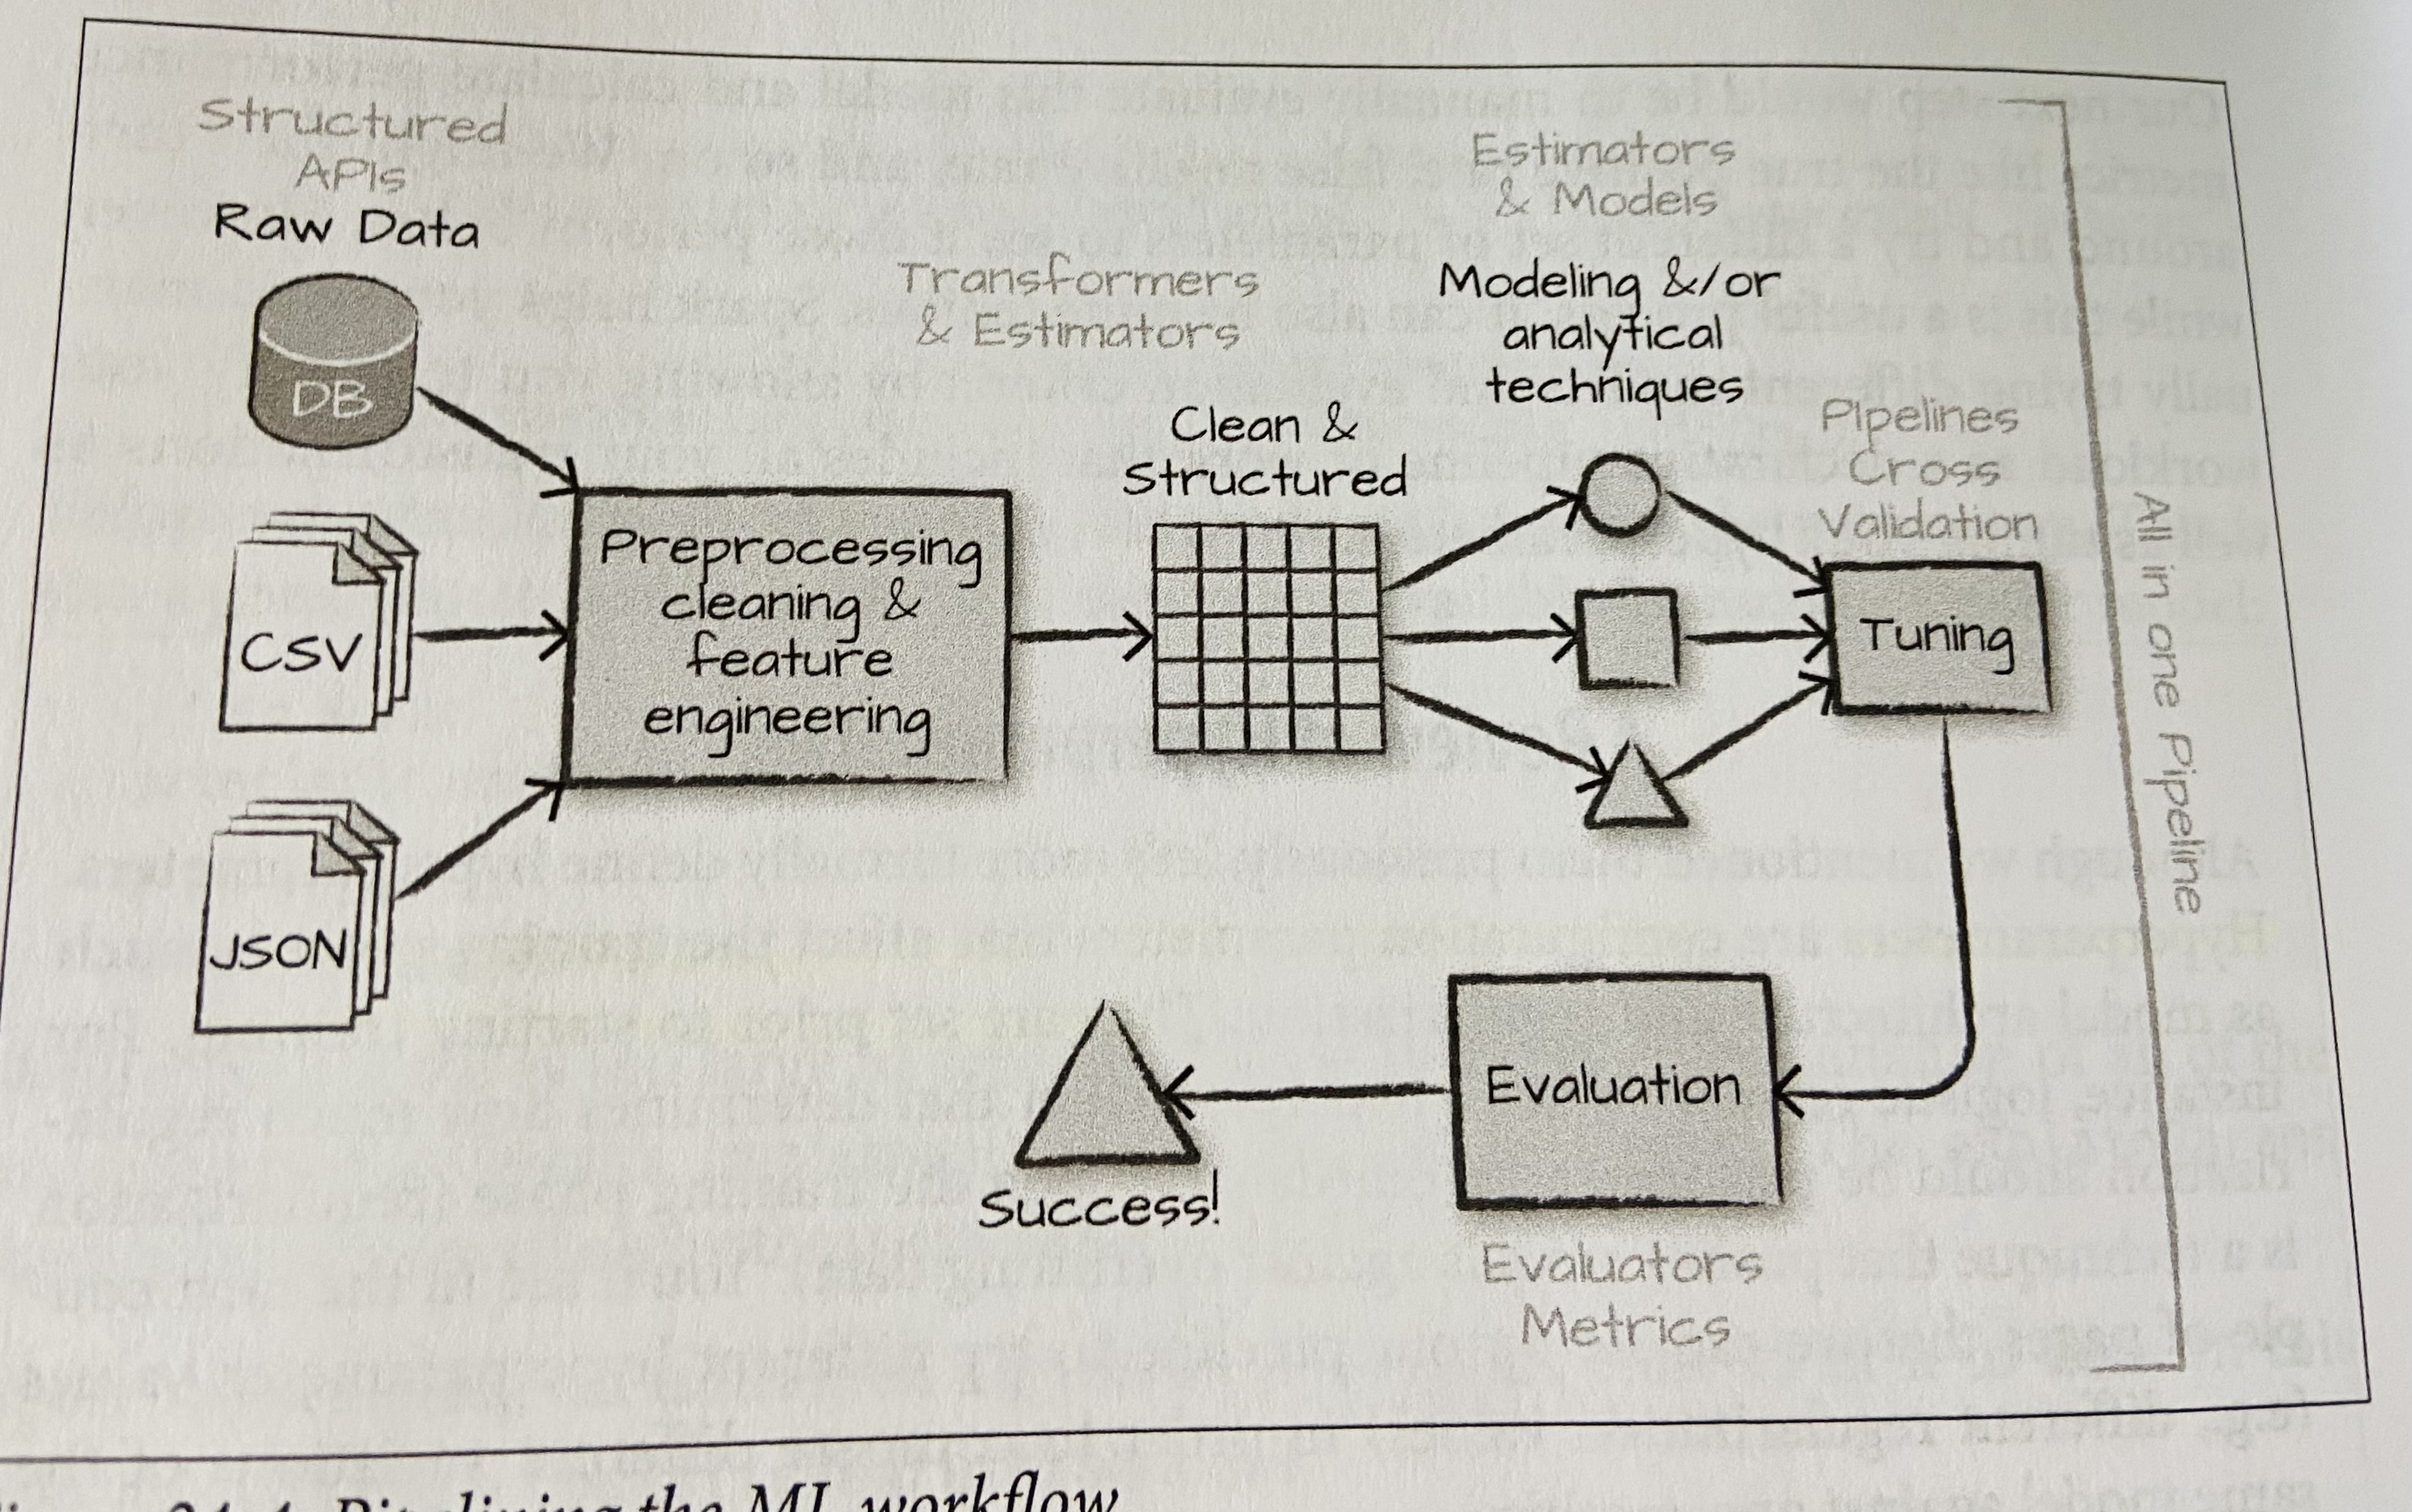

In [15]:
# Create a holdout test set and tune the hyperparameters based on a validation set
# (note that we create the validation set based on the original dataset, not the preparedDF)

train, test = df.randomSplit([0.8,0.2])

In [16]:
rForm = RFormula()
lr = LogisticRegression().setLabelCol("label").setFeaturesCol("features")

In [17]:
# Instead of manually using our transformations and then tuning the model,
  # we can make them stages in the overall pipeline

from pyspark.ml import Pipeline
stages = [rForm, lr]
pipeline = Pipeline().setStages(stages)

**Training and Evaluation**

* We train several varitations of the model by specifying different combinations of hyperparameters that we would like Spark to test. We'll then select the best model using an **Evaluator** that compares their predictions on our validation data.

* We can test different hyperparameters in the entire pipeline, even in the RFormula that we use to manipulate the raw data

In [18]:
from pyspark.ml.tuning import ParamGridBuilder

In [19]:
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
      "lab ~ . + color:value1",
      "lab ~ . + color:value1 + color:value2"])\
  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
  .addGrid(lr.regParam, [0.1, 2.0])\
  .build()

* **lr.elasticNetParam**: This is a hyperparameter of a LinearRegression model which controls the mix of L1 (Lasso) and L2 (Ridge) regularization.

* The values specified are 0.0, 0.5, and 1.0:
  * 0.0 corresponds to pure L2 regularization (Ridge).
  * 1.0 corresponds to pure L1 regularization (Lasso).
  * 0.5 is a mix of both L1 and L2 regularization.

* **lr.regParam**: This is the regularization parameter for the LinearRegression model. It controls the strength of the regularization. Two values are provided: 0.1 and 2.0.

* In our current parameter grid, there are 3 hyperparameters that will diverge from the defaults
  * Two different options of RFormula
  * Three different options of ElasticNet
  * Two different options of the regularization of parameters
# **↪** In total, we have 12 different combinations of these hyperparameters

* The next step after building the grid is to specify our evaluation process. The evaluator allows us to automatically and objectively compare multiple models on the same evaluation metric.
* We will further discuss the evaluators for classification and regression later on. In this case, we will use **BinaryClassificationEvaluator**. We will also use the **areaUncerROC**, which is the total area uncer the *receiver operating characteristic*, a common measure of classification performance

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [22]:
evaluator = BinaryClassificationEvaluator()\
  .setMetricName("areaUnderROC")\
  .setRawPredictionCol("prediction")\
  .setLabelCol("label")

* It's a best practice to fit hyperparameters on a validation set (instead of your test set) to prevent overfitting.
* Spark provides 2 options for performing hyperparameter tuning automatically:
  1.   **TrainValidationList**: simply perform an arbitrary random split of the data into 2 groups
  2.   **CrossValidator**: perform K-Fold cross validation by splitting dataset in to k non-overlapping, randomly partitioned fold



In [23]:
from pyspark.ml.tuning import TrainValidationSplit

In [24]:
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

In [25]:
tvsFitted = tvs.fit(train)

In [26]:
evaluator.evaluate(tvsFitted.transform(test))

0.9166666666666667

# **Persisting and Applying Models**:

We can persist the model to disk to use for prediction purpose later on

In [29]:
tvsFitted.write().overwrite().save("/content/drive/MyDrive")

# **Deployment Patterns**
  * Train ML model offline and supply it with offline data. The data is stored for analysis, and not data you need to get an answer from quickly.

  * Train ML model offline and then put the results into a database (key-value store). This works well for tasks like recommendation but works poorly for tasks like classfication or regression where you cannot just look up a value for a given user but must calculate one based on the input

  * Train ML model offline, persist to disk and then use that for serving. This is not low-latency solution, also doesn't parallelize well. So you'll likely have to put a **load balancer** in front of multiple model replicas and build out some REST API integration yoursel.

  * Manually (or via some other software) convert your distributed model thatn can run much more quickly on a single machine. This works well when there is not much manipulation on the raw data but hard to maintain over time.

  * Train your model online and use it online. This is possible when used in conjunction with Structured Streaming, but can be complex for some models

